In [157]:
import glob
from PIL import Image, ImageOps

img_count = 0

for im_path in glob.glob("/content/data/*.png"):
    img_count += 1

print("Number of images unzipped:", img_count)

Number of images unzipped: 9529


In [158]:
from PIL import Image
import numpy as np
import os

# Name of a new folder that will be made
new_folder_name = "nowy_folder"

# Path to a new folder in /content
new_folder_path = os.path.join("/content", new_folder_name)

# Creating new folder if it doesnt exist
os.makedirs(new_folder_path, exist_ok=True)

# Path to a folder with .png images
folder_path = "/content/data"

# List of images
images = []

# Converting all the files in a folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        # Loading an image and converting it to a grayscale image
        img = Image.open(os.path.join(folder_path, filename)).convert('L')

        # Numpy array convertion
        img_array = np.array(img)

        # Adding an image to an array
        images.append(img_array)

# Converting list to an array
images = np.array(images)

# Saving data to previously created folder
np.save(os.path.join(new_folder_path, 'images.npy'), images)

In [159]:
from sklearn.model_selection import train_test_split

# Reading data from a file
images = np.load('/content/nowy_folder/images.npy')

# Preparing data - normalization of pixel values to the range [0, 1]
images = images.astype('float32') / 255.0

# Spliting data into a training and test sets (80% train, 20% test)
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)


In [160]:
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np

In [161]:
# Using previously saved data
(x_train, x_test) = train_images, test_images
y_train, y_test = None, None  # In case of using labels

# Checking the dimensions of the data
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (7623, 30, 25)
x_test shape: (1906, 30, 25)


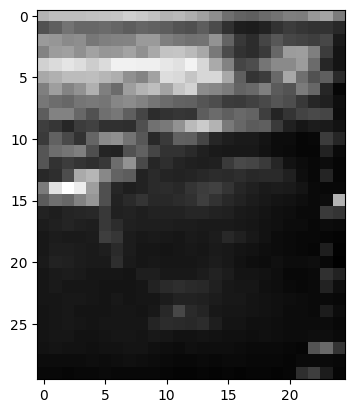

In [162]:
# Plotting image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

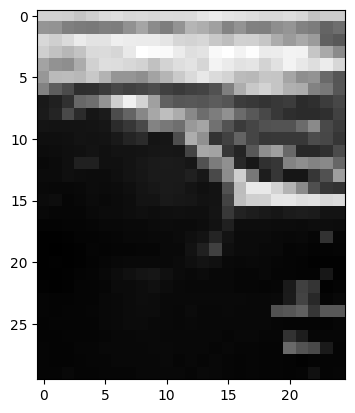

In [163]:
# Plotting image data from x_train
plt.imshow(x_test[0], cmap = "gray")
plt.show()

In [164]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Cropping2D
from keras.layers import Lambda

LATENT_SIZE = 64

encoder = Sequential([
    # Encoder layers
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(30, 25, 1)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(LATENT_SIZE, activation='relu')
])

decoder = Sequential([
    # Decoder layers
    Dense(1200, activation='relu', input_shape=(LATENT_SIZE,)),
    Reshape((4, 5, 60)),  # Adjust this shape based on the size before flattening in the encoder
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='valid'),  # Adjust padding here
    Lambda(lambda x: x[:, :30, :25, :])  # Custom lambda layer for cropping
])


# Combine encoder and decoder to create the autoencoder
autoencoder = Sequential([encoder, decoder])

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')  # Use mean_squared_error for reconstruction

# Display the model summary
autoencoder.summary()


Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_45 (Sequential)  (None, 64)                10160     
                                                                 
 sequential_46 (Sequential)  (None, 30, 25, 1)         84225     
                                                                 
Total params: 94385 (368.69 KB)
Trainable params: 94385 (368.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [165]:
EPOCHS = 60

1/1 [==============================] - 0s 20ms/step


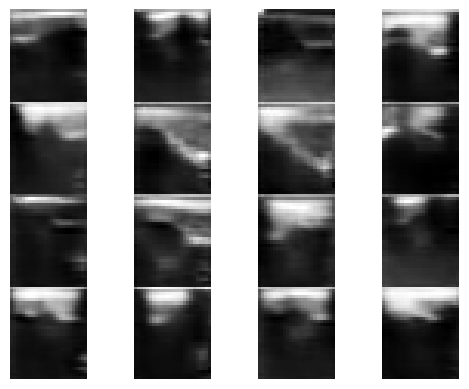

----------- EPOCH 59 -----------
239/239 [==============================] - 10s 42ms/step - loss: 0.0024


In [128]:
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython import display  # If you're using IPython for displaying
# import os

# # Directory to save encoded and decoded images
# save_dir_encoded = "/content/encoded"
# os.makedirs(save_dir_encoded, exist_ok=True)

# EPOCHS = 60  # Adjust the number of epochs as needed

# for epoch in range(EPOCHS):
#     fig, axs = plt.subplots(4, 4)

#     # Check the length of x_test
#     test_size = len(x_test)

#     # Ensure that the range for random indices is within the size of x_test
#     rand_indices = np.random.randint(0, test_size, 16)

#     # Reshape rand using rand_indices
#     rand = x_test[rand_indices].reshape((4, 4, 1, 30, 25))

#     display.clear_output()  # If imported display from IPython

#     encoded_images = []  # To store encoded images as NumPy arrays
#     decoded_images = []  # To store decoded images as NumPy arrays

#     for i in range(4):
#         for j in range(4):
#             # Predict and get the encoded image
#             encoded_image = autoencoder.layers[0].predict(rand[i, j])

#             # Save the encoded image as a NumPy array
#             encoded_images.append(encoded_image)

#             # Decode the image
#             decoded_image = autoencoder.predict(rand[i, j])[0]

#             # Save the decoded image as a NumPy array
#             decoded_images.append(decoded_image)

#             # Display the original and decoded images
#             axs[i, j].imshow(decoded_image, cmap="gray")
#             axs[i, j].axis("off")

#     # Convert the list of encoded images to a NumPy array
#     encoded_images_np = np.array(encoded_images)

#     # Save the NumPy array for encoded images
#     np.save(os.path.join(save_dir_encoded, f"encoded_images_epoch_{epoch}.npy"), encoded_images_np)

#     # Convert the list of decoded images to a NumPy array
#     decoded_images_np = np.array(decoded_images)

#     # Save the NumPy array for decoded images
#     np.save(os.path.join(save_dir_encoded, f"decoded_images_epoch_{epoch}.npy"), decoded_images_np)

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.show()
#     print("-----------", "EPOCH", epoch, "-----------")
#     autoencoder.fit(x_train, x_train)


1/1 [==============================] - 0s 34ms/step


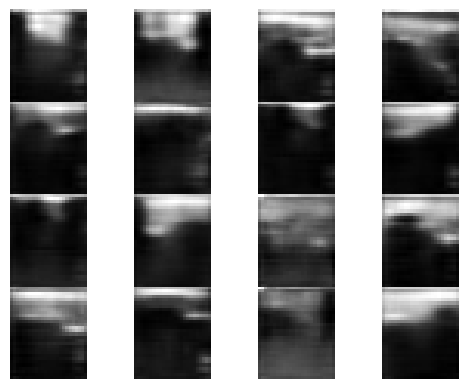

----------- EPOCH 59 -----------
239/239 [==============================] - 10s 41ms/step - loss: 0.0026


In [166]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display  # If you're using IPython for displaying
import os

# Directory to save encoded and decoded images
save_dir_encoded = "/content/encoded"
os.makedirs(save_dir_encoded, exist_ok=True)

EPOCHS = 60  # Adjust the number of epochs as needed

# Initialize lists to store all encoded and decoded images
all_encoded_images = []
all_decoded_images = []

for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)

    # Check the length of x_test
    test_size = len(x_test)

    # Ensure that the range for random indices is within the size of x_test
    rand_indices = np.random.randint(0, test_size, 16)

    # Reshape rand using rand_indices
    rand = x_test[rand_indices].reshape((4, 4, 1, 30, 25))

    display.clear_output()  # If imported display from IPython

    encoded_images = []  # To store encoded images as NumPy arrays
    decoded_images = []  # To store decoded images as NumPy arrays

    for i in range(4):
        for j in range(4):
            # Predict and get the encoded image
            encoded_image = autoencoder.layers[0].predict(rand[i, j])

            # Save the encoded image as a NumPy array
            encoded_images.append(encoded_image)

            # Decode the image
            decoded_image = autoencoder.predict(rand[i, j])[0]

            # Save the decoded image as a NumPy array
            decoded_images.append(decoded_image)

            # Display the original and decoded images
            axs[i, j].imshow(decoded_image, cmap="gray")
            axs[i, j].axis("off")

    # Extend the lists with the images from this epoch
    all_encoded_images.extend(encoded_images)
    all_decoded_images.extend(decoded_images)

    # Convert the list of encoded images to a NumPy array
    encoded_images_np = np.array(all_encoded_images)

    # Save the NumPy array for encoded images
    np.save(os.path.join(save_dir_encoded, f"encoded_images_epoch_{epoch}.npy"), encoded_images_np)

    # Convert the list of decoded images to a NumPy array
    decoded_images_np = np.array(all_decoded_images)

    # Save the NumPy array for decoded images
    np.save(os.path.join(save_dir_encoded, f"decoded_images_epoch_{epoch}.npy"), decoded_images_np)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    autoencoder.fit(x_train, x_train)


1/1 [==============================] - 0s 23ms/step


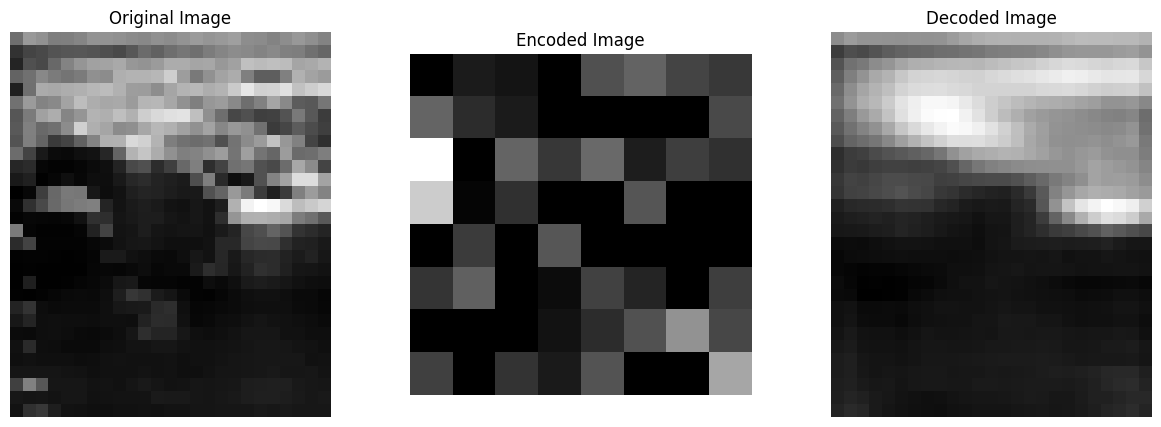

In [198]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_test is your original data
test_size = len(x_test)

# Choose a random index from x_test
rand_index = np.random.randint(0, test_size, 1)[0]
original_image = x_test[rand_index]

# Reshape for prediction
original_image_reshaped = original_image.reshape((1, 30, 25, 1))

# Predict and get the encoded image
encoded_image = autoencoder.layers[0].predict(original_image_reshaped)

# Decode the image
decoded_image = autoencoder.predict(original_image_reshaped)[0]

# Plot the original, encoded, and decoded images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axs[0].imshow(original_image, cmap="gray")  # Use original_image directly
axs[0].axis("off")
axs[0].set_title("Original Image")

# Encoded Image
axs[1].imshow(encoded_image.reshape((8, 8)), cmap="gray")  # Assuming the encoded image has a shape of (8, 8)
axs[1].axis("off")
axs[1].set_title("Encoded Image")

# Decoded Image
axs[2].imshow(decoded_image[:, :, 0], cmap="gray")
axs[2].axis("off")
axs[2].set_title("Decoded Image")

plt.show()


Loaded encoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

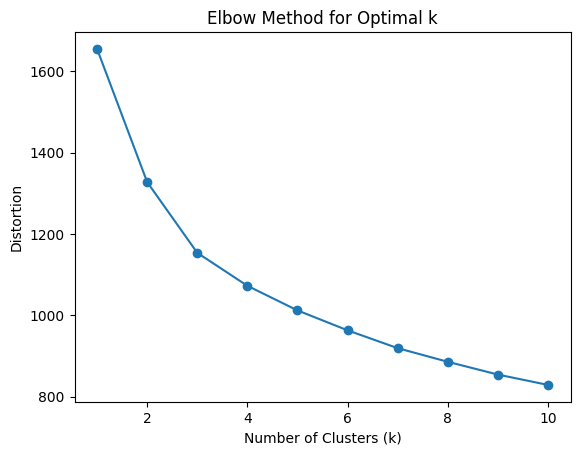

In [170]:
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Directory where encoded and decoded images are saved
encoded_dir = "/content/encoded"

# Load the encoded images from epoch 1
epoch_number = 59
encoded_file_path = os.path.join(encoded_dir, f"encoded_images_epoch_{epoch_number}.npy")

if os.path.exists(encoded_file_path):
    encoded_images_epoch = np.load(encoded_file_path)
    print(f"Loaded encoded images from epoch {epoch_number}.")

    # Reshape each encoded image to 2D (flatten each image into a vector)
    encoded_images_flat = encoded_images_epoch.reshape((-1, encoded_images_epoch.shape[1] * encoded_images_epoch.shape[2]))

    # Use the elbow method to find the optimal number of clusters
    distortions = []
    K_range = range(1, 11)  # Adjust the range based on your preferences
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(encoded_images_flat)
        distortions.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(K_range, distortions, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.show()

else:
    print(f"File not found: {encoded_file_path}")


Loaded encoded and decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


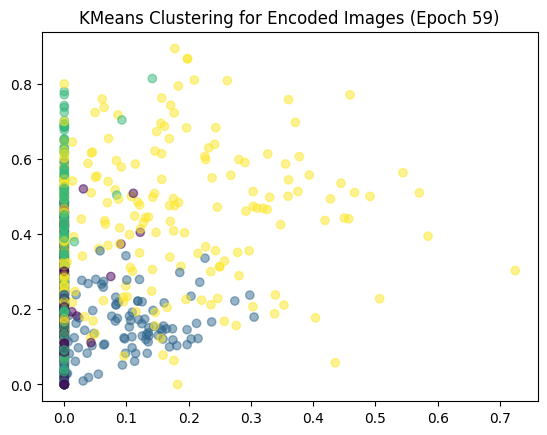

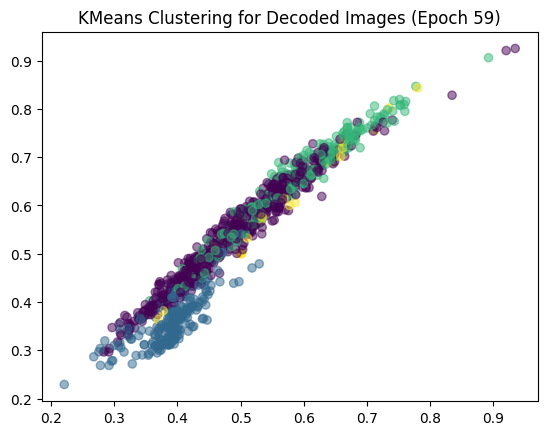

In [171]:
# Directory where encoded and decoded images are saved
encoded_dir = "/content/encoded"
decoded_dir = "/content/encoded"

# Load the encoded and decoded images from epoch 59
epoch_number = 59
encoded_file_path = os.path.join(encoded_dir, f"encoded_images_epoch_{epoch_number}.npy")
decoded_file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

if os.path.exists(encoded_file_path) and os.path.exists(decoded_file_path):
    encoded_images_epoch = np.load(encoded_file_path)
    decoded_images_epoch = np.load(decoded_file_path)
    print(f"Loaded encoded and decoded images from epoch {epoch_number}.")

    # Reshape each encoded and decoded image to 2D (flatten each image into a vector)
    encoded_images_flat = encoded_images_epoch[:num_points].reshape((-1, encoded_images_epoch.shape[1] * encoded_images_epoch.shape[2]))
    decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

    # Specify the number of clusters
    num_clusters = 4  # Adjust based on specific use case

    # Apply KMeans clustering for encoded images
    kmeans_encoded = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels_encoded = kmeans_encoded.fit_predict(encoded_images_flat)

    # Apply KMeans clustering for decoded images
    kmeans_decoded = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels_decoded = kmeans_decoded.fit_predict(decoded_images_flat)

    # Visualize the clustering results for encoded images
    plt.scatter(encoded_images_flat[:, 0], encoded_images_flat[:, 1], c=cluster_labels_encoded, cmap='viridis', alpha=0.5)
    plt.title(f'KMeans Clustering for Encoded Images (Epoch {epoch_number})')
    plt.show()

    # Visualize the clustering results for decoded images
    plt.scatter(decoded_images_flat[:, 0], decoded_images_flat[:, 1], c=cluster_labels_decoded, cmap='viridis', alpha=0.5)
    plt.title(f'KMeans Clustering for Decoded Images (Epoch {epoch_number})')
    plt.show()

else:
    print(f"File not found: {encoded_file_path} or {decoded_file_path}")


Loaded encoded and decoded images from epoch 1.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for Encoded Images (Epoch 1): 0.669971227645874


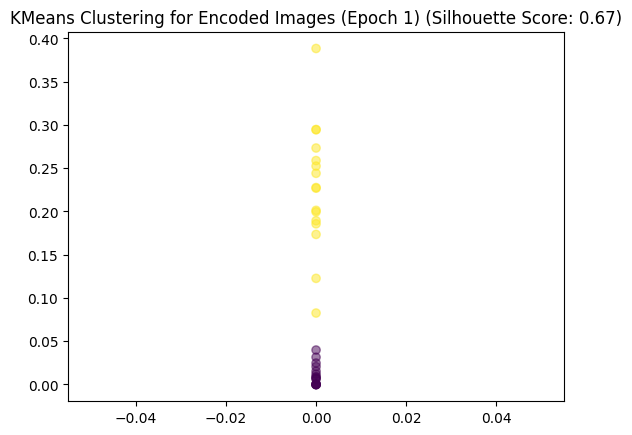

Silhouette Score for Decoded Images (Epoch 1): 0.7684895992279053


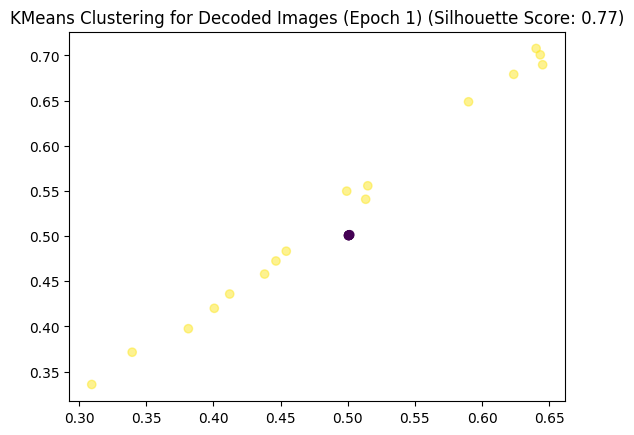

Loaded encoded and decoded images from epoch 25.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for Encoded Images (Epoch 25): 0.1754133105278015


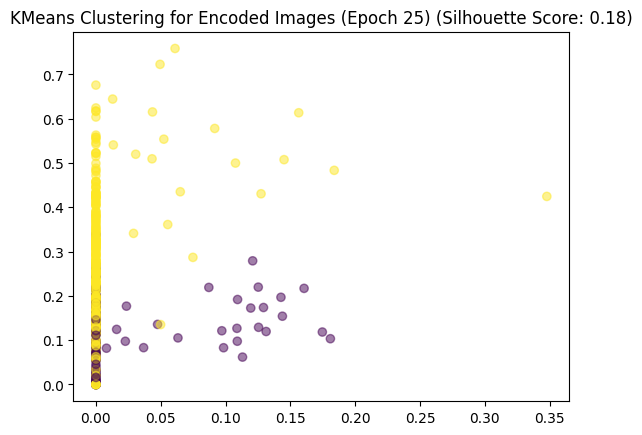

Silhouette Score for Decoded Images (Epoch 25): 0.30693358182907104


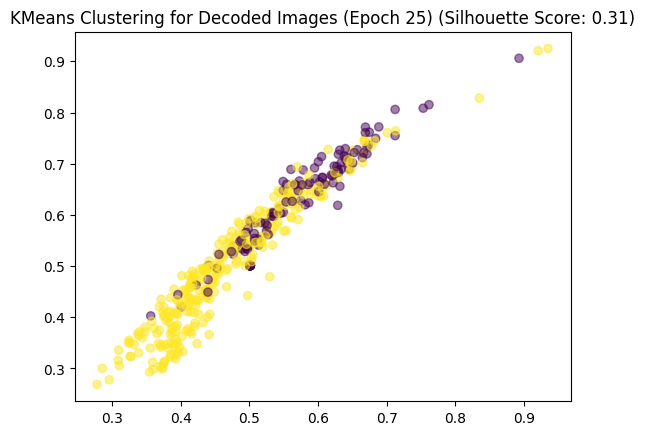

Loaded encoded and decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for Encoded Images (Epoch 59): 0.1697656661272049


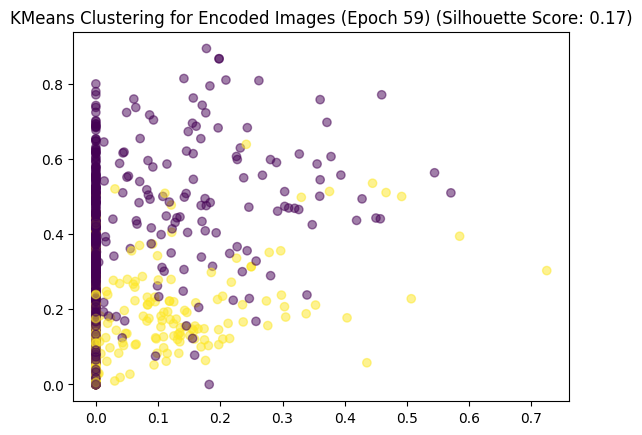

Silhouette Score for Decoded Images (Epoch 59): 0.2563512325286865


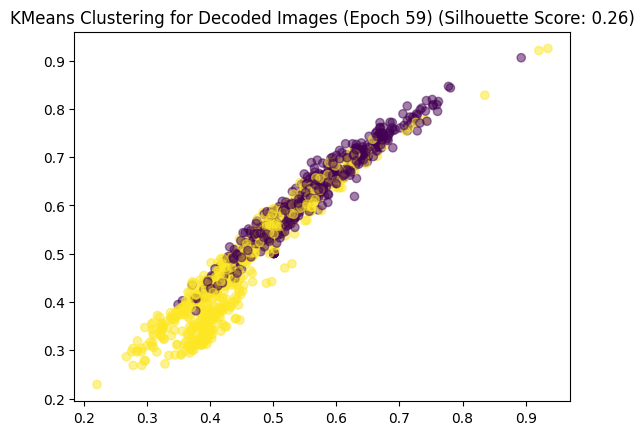

In [174]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def cluster_and_visualize(epoch_number, num_clusters=2):
    # Directory where encoded and decoded images are saved
    encoded_dir = "/content/encoded"
    decoded_dir = "/content/encoded"

    # Load the encoded and decoded images from the specified epoch
    encoded_file_path = os.path.join(encoded_dir, f"encoded_images_epoch_{epoch_number}.npy")
    decoded_file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

    if os.path.exists(encoded_file_path) and os.path.exists(decoded_file_path):
        encoded_images_epoch = np.load(encoded_file_path)
        decoded_images_epoch = np.load(decoded_file_path)
        print(f"Loaded encoded and decoded images from epoch {epoch_number}.")

        # Reshape each encoded and decoded image to 2D (flatten each image into a vector)
        encoded_images_flat = encoded_images_epoch.reshape((-1, encoded_images_epoch.shape[1] * encoded_images_epoch.shape[2]))
        decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

        # Apply KMeans clustering for encoded images
        kmeans_encoded = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels_encoded = kmeans_encoded.fit_predict(encoded_images_flat)

        # Apply KMeans clustering for decoded images
        kmeans_decoded = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels_decoded = kmeans_decoded.fit_predict(decoded_images_flat)

        # Calculate silhouette score for encoded images
        silhouette_avg_encoded = silhouette_score(encoded_images_flat, cluster_labels_encoded)
        print(f"Silhouette Score for Encoded Images (Epoch {epoch_number}): {silhouette_avg_encoded}")

        # Visualize the clustering results for encoded images
        plt.scatter(encoded_images_flat[:, 0], encoded_images_flat[:, 1], c=cluster_labels_encoded, cmap='viridis', alpha=0.5)
        plt.title(f'KMeans Clustering for Encoded Images (Epoch {epoch_number}) (Silhouette Score: {silhouette_avg_encoded:.2f})')
        plt.show()

        # Calculate silhouette score for decoded images
        silhouette_avg_decoded = silhouette_score(decoded_images_flat, cluster_labels_decoded)
        print(f"Silhouette Score for Decoded Images (Epoch {epoch_number}): {silhouette_avg_decoded}")

        # Visualize the clustering results for decoded images
        plt.scatter(decoded_images_flat[:, 0], decoded_images_flat[:, 1], c=cluster_labels_decoded, cmap='viridis', alpha=0.5)
        plt.title(f'KMeans Clustering for Decoded Images (Epoch {epoch_number}) (Silhouette Score: {silhouette_avg_decoded:.2f})')
        plt.show()

    else:
        print(f"File not found: {encoded_file_path} or {decoded_file_path}")

# Call the function for epochs 1, 25, and 59
for epoch in [1, 25, 59]:
    cluster_and_visualize(epoch)


Loaded encoded and decoded images from epoch 1.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


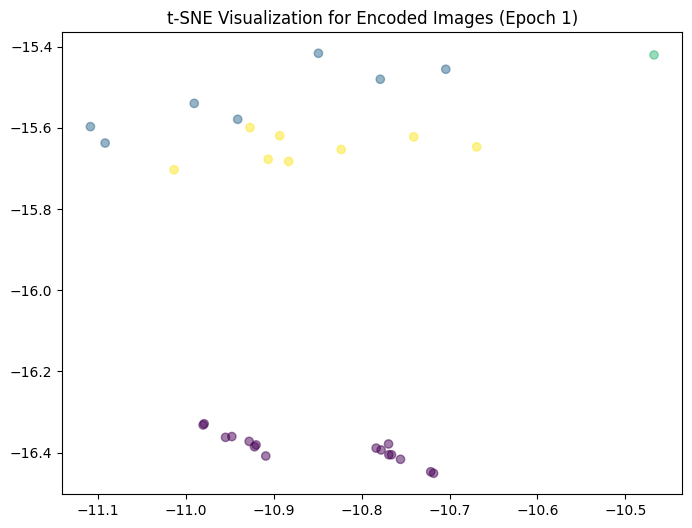

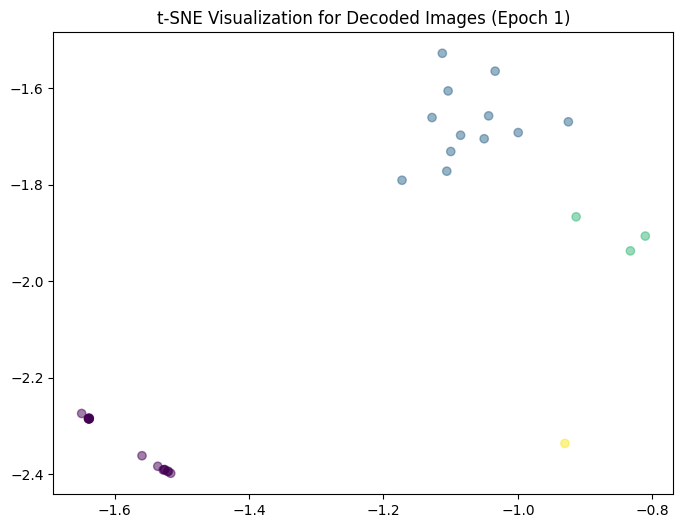

Loaded encoded and decoded images from epoch 25.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


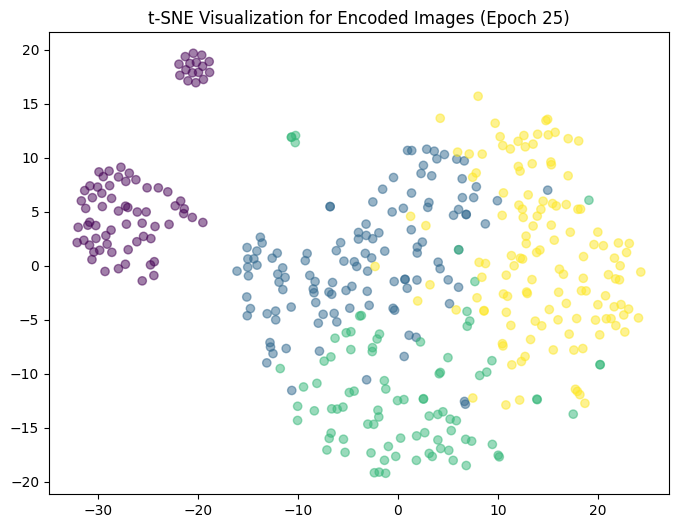

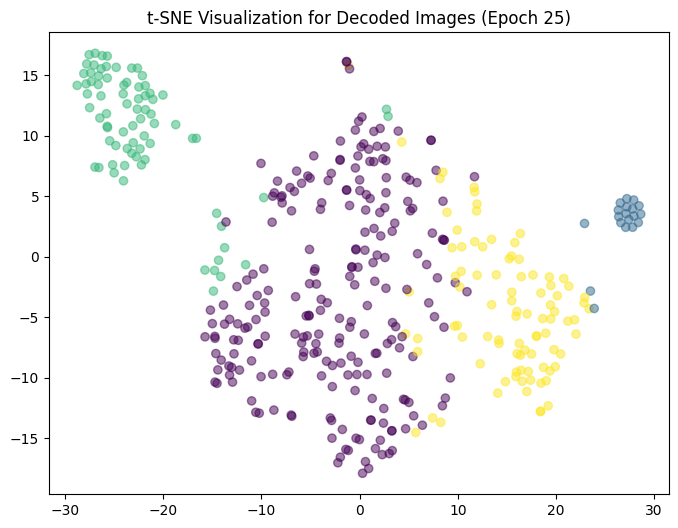

Loaded encoded and decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


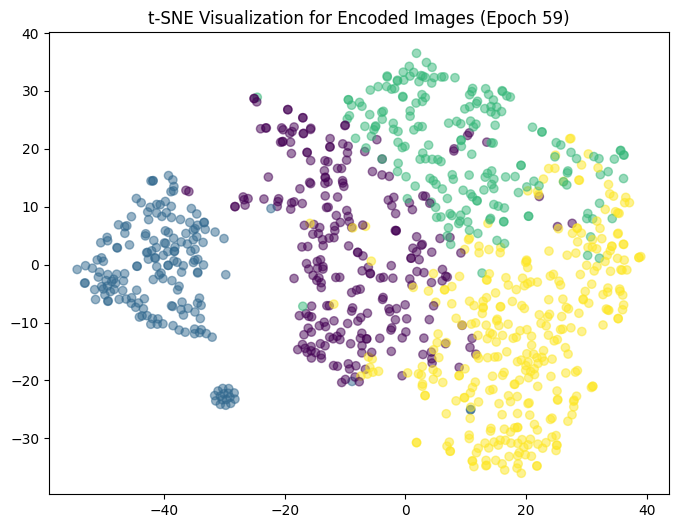

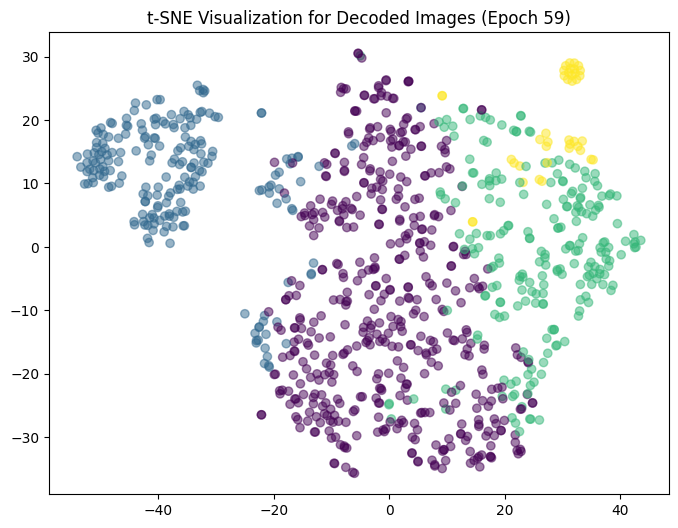

In [177]:
import os
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def visualize_tsne(data_flat, cluster_labels, epoch_number, title):
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embedded_data = tsne.fit_transform(data_flat)

    # Visualize the t-SNE plot with cluster labels
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.show()

# Directory where encoded and decoded images are saved
encoded_dir = "/content/encoded"
decoded_dir = "/content/encoded"

# Specify the epochs to visualize
epochs_to_visualize = [1, 25, 59]

for epoch_number in epochs_to_visualize:
    # Load the encoded and decoded images from the specified epoch
    encoded_file_path = os.path.join(encoded_dir, f"encoded_images_epoch_{epoch_number}.npy")
    decoded_file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

    if os.path.exists(encoded_file_path) and os.path.exists(decoded_file_path):
        encoded_images_epoch = np.load(encoded_file_path)
        decoded_images_epoch = np.load(decoded_file_path)
        print(f"Loaded encoded and decoded images from epoch {epoch_number}.")

        # Reshape each encoded and decoded image to 2D (flatten each image into a vector)
        encoded_images_flat = encoded_images_epoch.reshape((-1, encoded_images_epoch.shape[1] * encoded_images_epoch.shape[2]))
        decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

        # Apply KMeans clustering for encoded images
        kmeans_encoded = KMeans(n_clusters=4, random_state=42)
        cluster_labels_encoded = kmeans_encoded.fit_predict(encoded_images_flat)

        # Apply KMeans clustering for decoded images
        kmeans_decoded = KMeans(n_clusters=4, random_state=42)
        cluster_labels_decoded = kmeans_decoded.fit_predict(decoded_images_flat)

        # Visualize t-SNE for encoded images
        visualize_tsne(encoded_images_flat, cluster_labels_encoded, epoch_number, f't-SNE Visualization for Encoded Images (Epoch {epoch_number})')

        # Visualize t-SNE for decoded images
        visualize_tsne(decoded_images_flat, cluster_labels_decoded, epoch_number, f't-SNE Visualization for Decoded Images (Epoch {epoch_number})')

    else:
        print(f"File not found: {encoded_file_path} or {decoded_file_path}")


Loaded encoded and decoded images from epoch 1.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


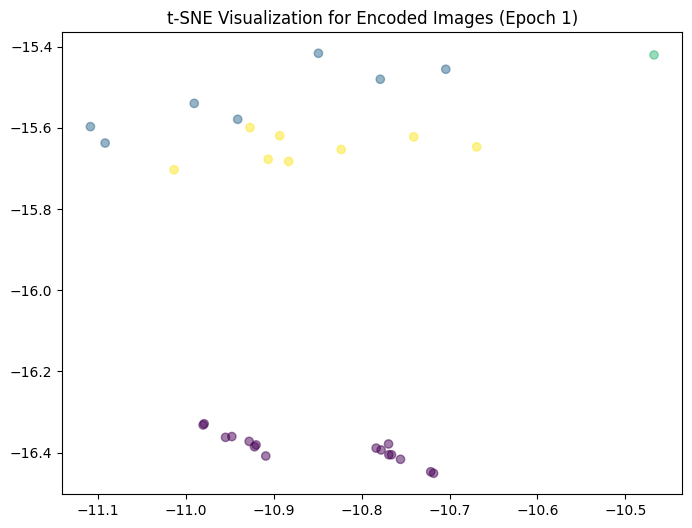

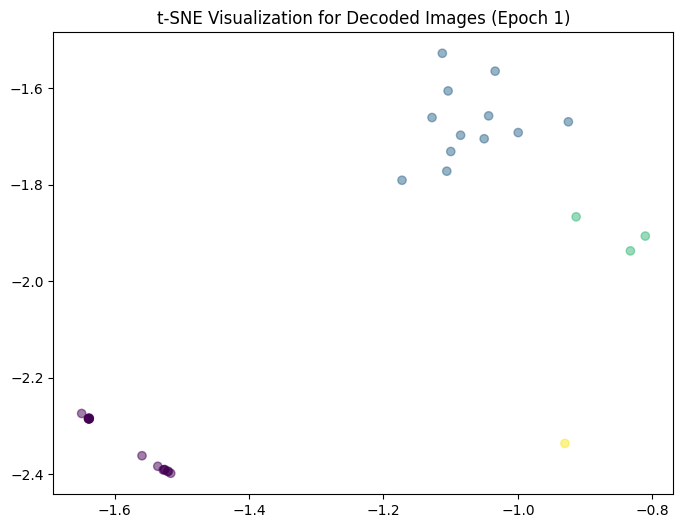

Loaded encoded and decoded images from epoch 25.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



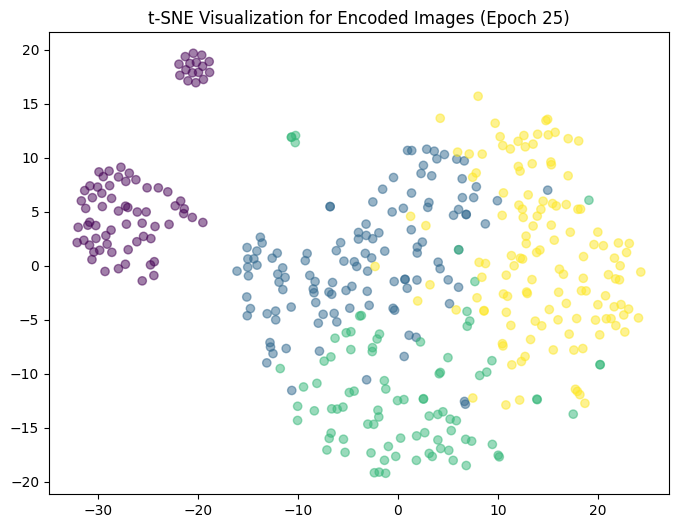

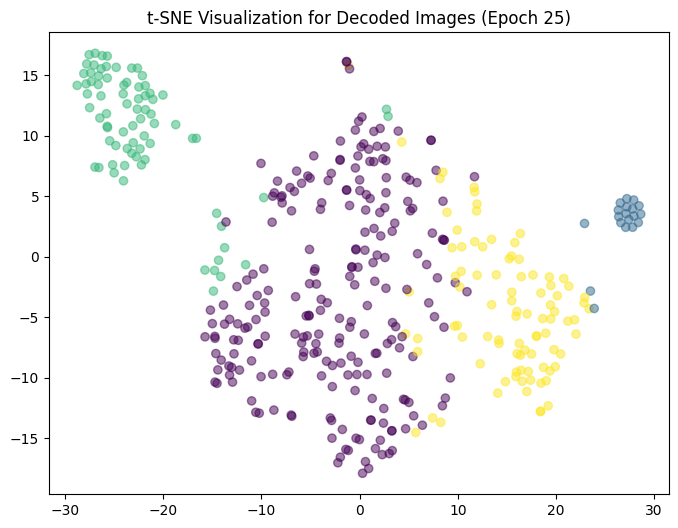

Loaded encoded and decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



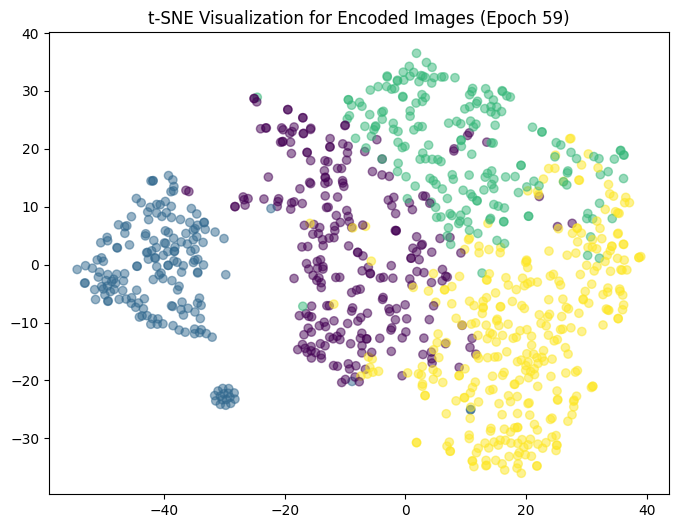

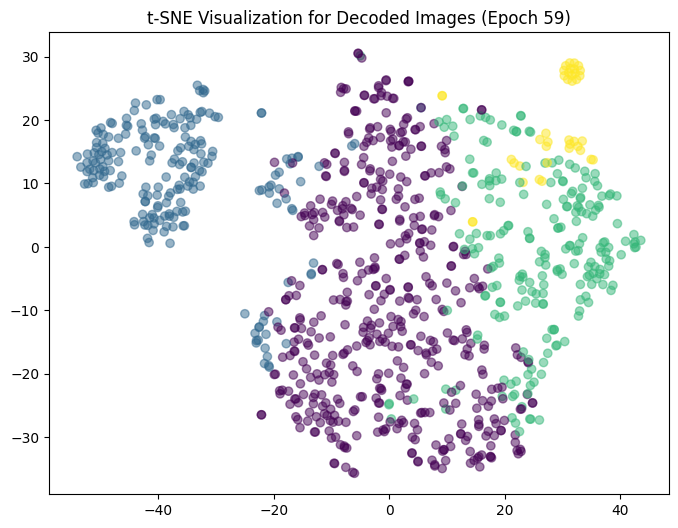

In [179]:
import os
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

def visualize_tsne(data_flat, cluster_labels, epoch_number, title, use_plotly=False):
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embedded_data = tsne.fit_transform(data_flat)

    if not use_plotly:
        # Visualize the t-SNE plot with cluster labels using Matplotlib
        plt.figure(figsize=(8, 6))
        plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
        plt.title(title)
        plt.show()
    else:
        # Visualize the t-SNE plot with cluster labels using Plotly
        df_tsne = pd.DataFrame({'X': embedded_data[:, 0], 'Y': embedded_data[:, 1], 'Cluster': cluster_labels})
        fig = px.scatter(df_tsne, x='X', y='Y', color='Cluster', opacity=0.7, title=title)
        fig.show()

# Directory where encoded and decoded images are saved
encoded_dir = "/content/encoded"
decoded_dir = "/content/encoded"

# Specify the epochs to visualize
epochs_to_visualize = [1, 25, 59]

for epoch_number in epochs_to_visualize:
    # Load the encoded and decoded images from the specified epoch
    encoded_file_path = os.path.join(encoded_dir, f"encoded_images_epoch_{epoch_number}.npy")
    decoded_file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

    if os.path.exists(encoded_file_path) and os.path.exists(decoded_file_path):
        encoded_images_epoch = np.load(encoded_file_path)
        decoded_images_epoch = np.load(decoded_file_path)
        print(f"Loaded encoded and decoded images from epoch {epoch_number}.")

        # Reshape each encoded and decoded image to 2D (flatten each image into a vector)
        encoded_images_flat = encoded_images_epoch.reshape((-1, encoded_images_epoch.shape[1] * encoded_images_epoch.shape[2]))
        decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

        # Apply KMeans clustering for encoded images
        kmeans_encoded = KMeans(n_clusters=4, random_state=42)
        cluster_labels_encoded = kmeans_encoded.fit_predict(encoded_images_flat)

        # Apply KMeans clustering for decoded images
        kmeans_decoded = KMeans(n_clusters=4, random_state=42)
        cluster_labels_decoded = kmeans_decoded.fit_predict(decoded_images_flat)

        # Visualize t-SNE for encoded images (Matplotlib)
        visualize_tsne(encoded_images_flat, cluster_labels_encoded, epoch_number, f't-SNE Visualization for Encoded Images (Epoch {epoch_number})', use_plotly=False)

        # Visualize t-SNE for decoded images (Matplotlib)
        visualize_tsne(decoded_images_flat, cluster_labels_decoded, epoch_number, f't-SNE Visualization for Decoded Images (Epoch {epoch_number})', use_plotly=False)

        # Visualize t-SNE for encoded images (Plotly)
        visualize_tsne(encoded_images_flat, cluster_labels_encoded, epoch_number, f't-SNE Visualization for Encoded Images (Epoch {epoch_number})', use_plotly=True)

        # Visualize t-SNE for decoded images (Plotly)
        visualize_tsne(decoded_images_flat, cluster_labels_decoded, epoch_number, f't-SNE Visualization for Decoded Images (Epoch {epoch_number})', use_plotly=True)

    else:
        print(f"File not found: {encoded_file_path} or {decoded_file_path}")


Loaded encoded and decoded images from epoch 1.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



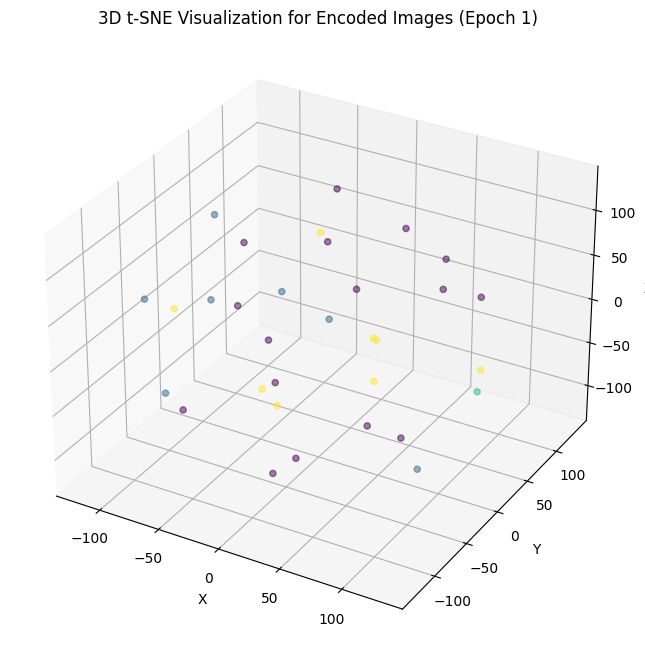

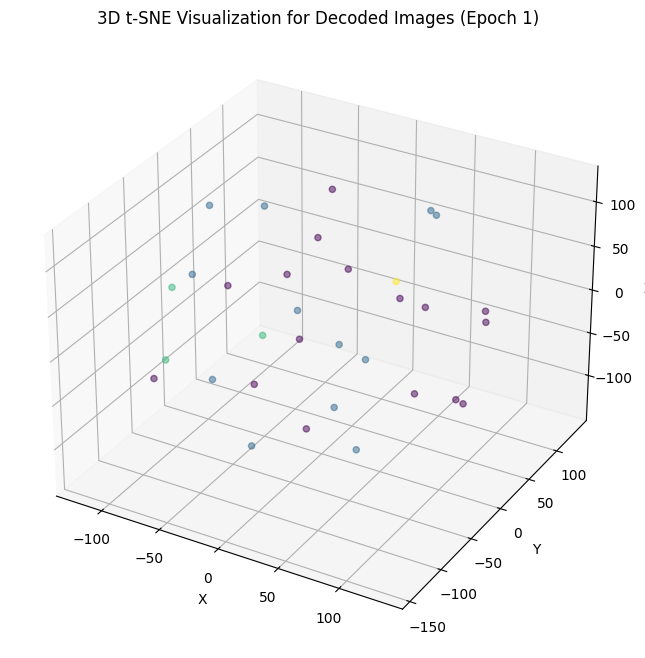

Loaded encoded and decoded images from epoch 25.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



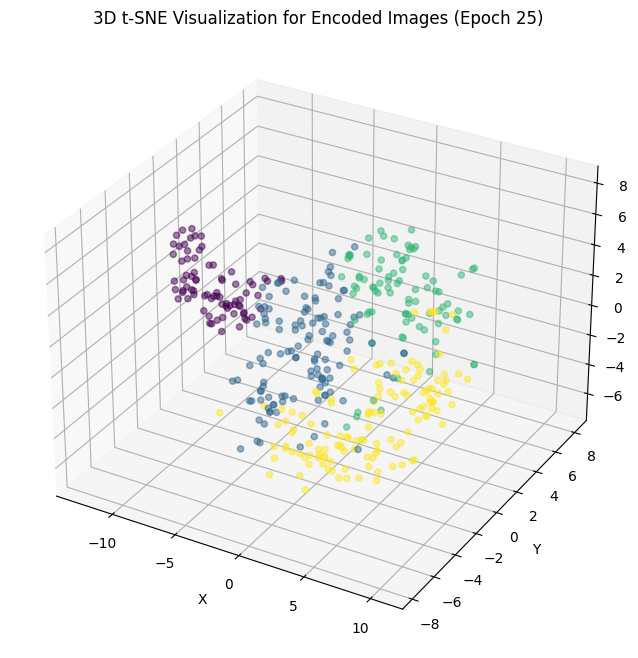

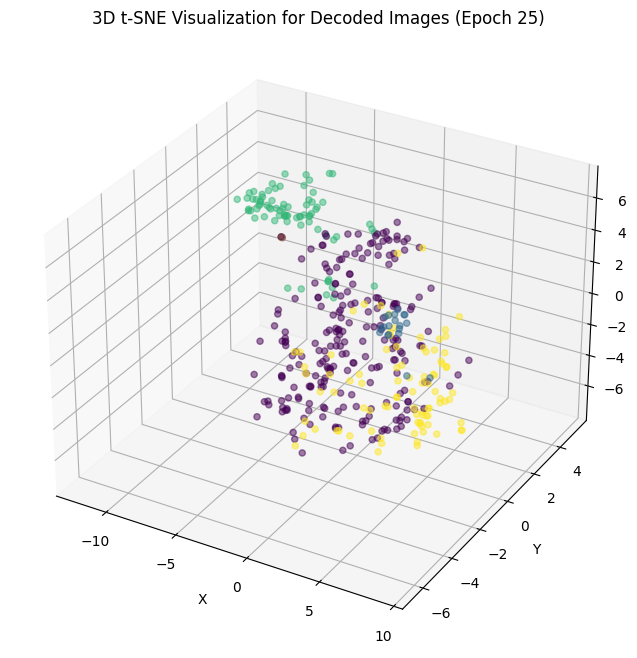

Loaded encoded and decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



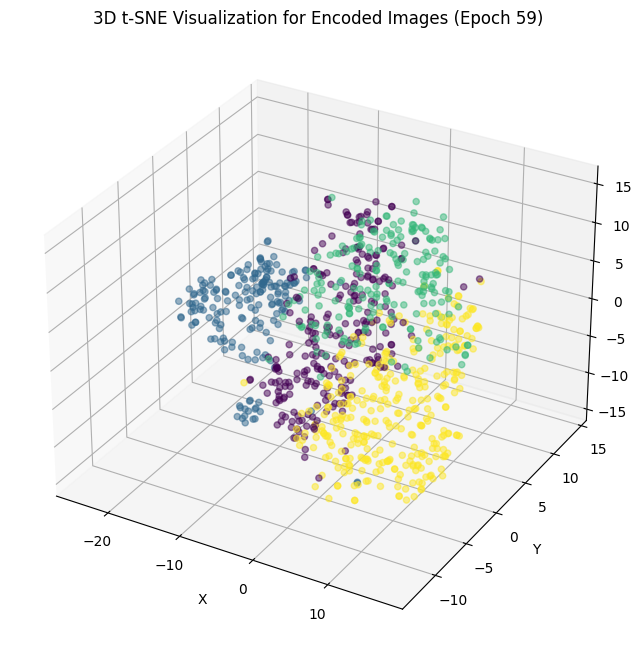

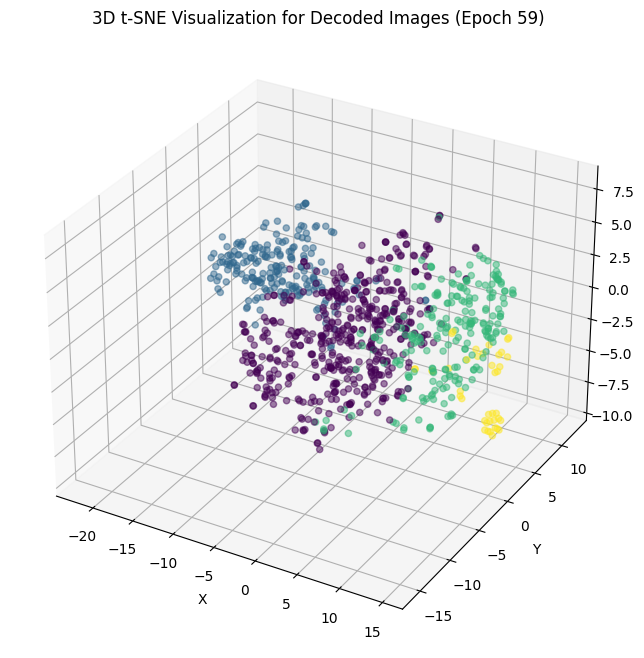

In [180]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

def visualize_tsne_3d(data_flat, cluster_labels, epoch_number, title, use_plotly=False):
    # Apply t-SNE with 3D visualization
    tsne = TSNE(n_components=3, random_state=42)
    embedded_data = tsne.fit_transform(data_flat)

    if not use_plotly:
        # Visualize the 3D t-SNE plot with cluster labels using Matplotlib
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], c=cluster_labels, cmap='viridis', alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    else:
        # Visualize the 3D t-SNE plot with cluster labels using Plotly
        df_tsne = pd.DataFrame({'X': embedded_data[:, 0], 'Y': embedded_data[:, 1], 'Z': embedded_data[:, 2], 'Cluster': cluster_labels})
        fig = px.scatter_3d(df_tsne, x='X', y='Y', z='Z', color='Cluster', opacity=0.7, title=title)
        fig.show()

# Directory where encoded and decoded images are saved
encoded_dir = "/content/encoded"
decoded_dir = "/content/encoded"

# Specify the epochs to visualize
epochs_to_visualize = [1, 25, 59]

for epoch_number in epochs_to_visualize:
    # Load the encoded and decoded images from the specified epoch
    encoded_file_path = os.path.join(encoded_dir, f"encoded_images_epoch_{epoch_number}.npy")
    decoded_file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

    if os.path.exists(encoded_file_path) and os.path.exists(decoded_file_path):
        encoded_images_epoch = np.load(encoded_file_path)
        decoded_images_epoch = np.load(decoded_file_path)
        print(f"Loaded encoded and decoded images from epoch {epoch_number}.")

        # Reshape each encoded and decoded image to 1D (flatten each image into a vector)
        encoded_images_flat = encoded_images_epoch.reshape((-1, encoded_images_epoch.shape[1] * encoded_images_epoch.shape[2]))
        decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

        # Apply KMeans clustering for encoded images
        kmeans_encoded = KMeans(n_clusters=4, random_state=42)
        cluster_labels_encoded = kmeans_encoded.fit_predict(encoded_images_flat)

        # Apply KMeans clustering for decoded images
        kmeans_decoded = KMeans(n_clusters=4, random_state=42)
        cluster_labels_decoded = kmeans_decoded.fit_predict(decoded_images_flat)

        # Visualize 3D t-SNE for encoded images (Matplotlib)
        visualize_tsne_3d(encoded_images_flat, cluster_labels_encoded, epoch_number, f'3D t-SNE Visualization for Encoded Images (Epoch {epoch_number})', use_plotly=False)

        # Visualize 3D t-SNE for decoded images (Matplotlib)
        visualize_tsne_3d(decoded_images_flat, cluster_labels_decoded, epoch_number, f'3D t-SNE Visualization for Decoded Images (Epoch {epoch_number})', use_plotly=False)

        # Visualize 3D t-SNE for encoded images (Plotly)
        visualize_tsne_3d(encoded_images_flat, cluster_labels_encoded, epoch_number, f'3D t-SNE Visualization for Encoded Images (Epoch {epoch_number})', use_plotly=True)

        # Visualize 3D t-SNE for decoded images (Plotly)
        visualize_tsne_3d(decoded_images_flat, cluster_labels_decoded, epoch_number, f'3D t-SNE Visualization for Decoded Images (Epoch {epoch_number})', use_plotly=True)

    else:
        print(f"File not found: {encoded_file_path} or {decoded_file_path}")


Loaded encoded and decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



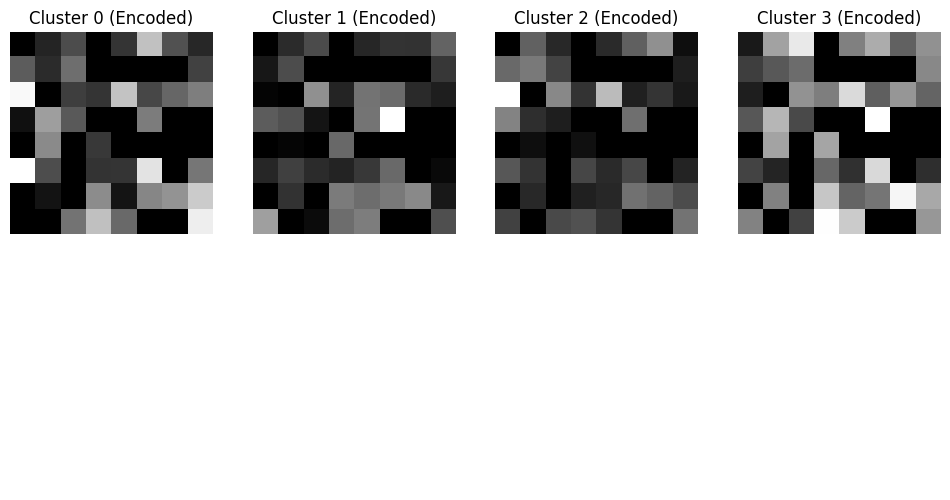

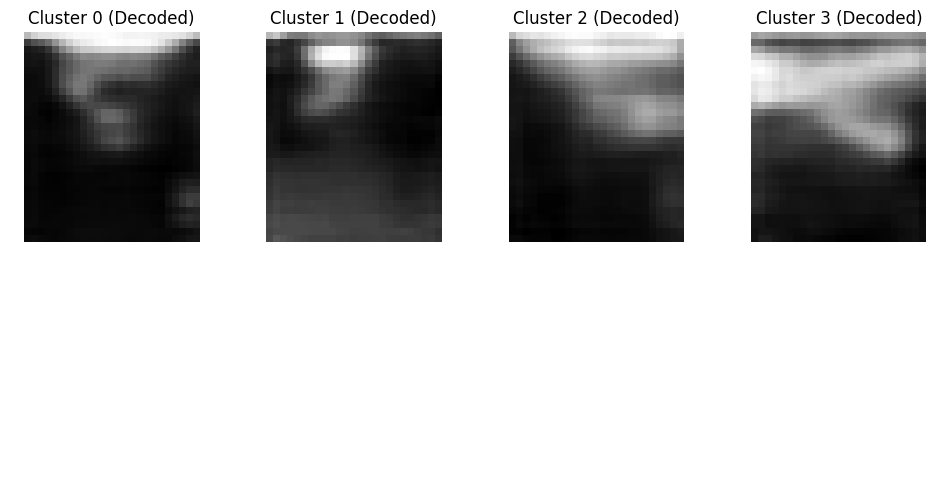

In [195]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# Directory where encoded and decoded images are saved
encoded_dir = "/content/encoded"
decoded_dir = "/content/encoded"

# Specify the epoch to visualize
epoch_number = 59

# Load the encoded and decoded images from the specified epoch
encoded_file_path = os.path.join(encoded_dir, f"encoded_images_epoch_{epoch_number}.npy")
decoded_file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

if os.path.exists(encoded_file_path) and os.path.exists(decoded_file_path):
    encoded_images_epoch = np.load(encoded_file_path)
    decoded_images_epoch = np.load(decoded_file_path)
    print(f"Loaded encoded and decoded images from epoch {epoch_number}.")

    # Apply KMeans clustering for encoded and decoded images
    kmeans_encoded = KMeans(n_clusters=4, random_state=42)
    cluster_labels_encoded = kmeans_encoded.fit_predict(encoded_images_epoch.reshape((-1, np.prod(encoded_images_epoch.shape[1:]))))

    kmeans_decoded = KMeans(n_clusters=4, random_state=42)
    cluster_labels_decoded = kmeans_decoded.fit_predict(decoded_images_epoch.reshape((-1, np.prod(decoded_images_epoch.shape[1:]))))

    # Display encoded images in an 8x8 grid without axis labels
    fig_encoded, axs_encoded = plt.subplots(2, 4, figsize=(12, 6))

    for cluster in np.unique(cluster_labels_encoded):
        # Display a random encoded image
        indices_encoded = np.where(cluster_labels_encoded == cluster)[0]
        random_index_encoded = random.choice(indices_encoded)
        encoded_image = encoded_images_epoch[random_index_encoded]

        axs_encoded[0, cluster].imshow(encoded_image.reshape((8, 8)), cmap="gray")
        axs_encoded[0, cluster].set_title(f'Cluster {cluster} (Encoded)')
        axs_encoded[0, cluster].axis("off")

    # Remove borderlines from the axis
    for ax in axs_encoded.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

    # Display decoded images without axis labels
    fig_decoded, axs_decoded = plt.subplots(2, 4, figsize=(12, 6))

    for cluster in np.unique(cluster_labels_decoded):
        # Display a random decoded image
        indices_decoded = np.where(cluster_labels_decoded == cluster)[0]
        random_index_decoded = random.choice(indices_decoded)
        decoded_image = decoded_images_epoch[random_index_decoded]

        axs_decoded[0, cluster].imshow(decoded_image, cmap="gray")
        axs_decoded[0, cluster].set_title(f'Cluster {cluster} (Decoded)')
        axs_decoded[0, cluster].axis("off")

    # Remove borderlines from the axis
    for ax in axs_decoded.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

else:
    print(f"File not found: {encoded_file_path} or {decoded_file_path}")
